In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE

import brain_observatory_utilities.datasets.optical_physiology.data_formatting as ophys_formatting
import brain_observatory_utilities.utilities.general_utilities as utilities

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

In [5]:
datafolder = "D:\\neuromatch2024\\datasets\\project\\Allen\\temp\\"
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=datafolder)

ophys_experiment_ids = [854759890, 854759894, 854759896, 854759898]

experiments = {}
# ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id']
for ophys_experiment_id in ophys_experiment_ids:
    experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(
        ophys_experiment_id
    )

c:\Users\bosem\miniconda3\envs\allenSDK\lib\site-packages\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(
c:\Users\bosem\miniconda3\envs\allenSDK\lib\site-packages\hdmf\utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  retur

In [6]:
neural_data = []
for ophys_experiment_id in ophys_experiment_ids:
    this_experiment = experiments[ophys_experiment_id]
    this_experiment_neural_data = ophys_formatting.build_tidy_cell_df(this_experiment)

    # add some columns with metadata for the experiment
    metadata_keys = [
        "ophys_experiment_id",
        "ophys_session_id",
        "targeted_structure",
        "imaging_depth",
        "equipment_name",
        "cre_line",
        "mouse_id",
        "sex",
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[
            metadata_key
        ]

    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)

# concatate the list of dataframes into a single dataframe
neural_data = pd.concat(neural_data)

In [8]:
neural_data.head()

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,10.52216,0.400583,0.0,0.0,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
1,10.61538,0.126125,0.0,0.0,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
2,10.70860,-0.083087,0.0,0.0,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
3,10.80182,0.158960,0.0,0.0,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
4,10.89504,0.301507,0.0,0.0,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M


In [9]:
cell_ids = neural_data['cell_specimen_id'].unique()
print('there are {} unique cells'.format(len(cell_ids)))
print('cell ids are: {}'.format(cell_ids))

there are 31 unique cells
cell ids are: [1086550481 1086551114 1086551301 1086557083 1086557639 1086559064
 1086558114 1086558224 1086558510 1086559206 1086557304 1086557208
 1086560061 1086559681 1086559885 1086559968 1086557470 1086547796
 1086547993 1086548118 1086554566 1086556653 1086558574 1086552296
 1086558071 1086556532 1086555222 1086558701 1086557434 1086556317
 1086555835]


In [14]:
snt = neural_data[neural_data.cell_specimen_id == 1086550481].reset_index(drop=True)
snt.head()

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,10.52216,0.400583,0.0,0.0,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
1,10.61538,0.126125,0.0,0.0,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
2,10.70860,-0.083087,0.0,0.0,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
3,10.80182,0.158960,0.0,0.0,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
4,10.89504,0.301507,0.0,0.0,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M


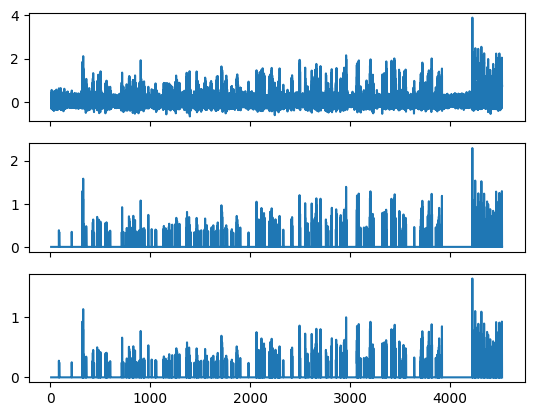

In [17]:
fig,ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].plot(snt.timestamps, snt.dff);
ax[1].plot(snt.timestamps, snt.events);
ax[2].plot(snt.timestamps, snt.filtered_events);


In [50]:
stimulus_table = experiments[ophys_experiment_ids[0]].stimulus_presentations
omission_start_times = stimulus_table[stimulus_table.omitted].start_time.values 
omission_end_times = stimulus_table[stimulus_table.omitted].end_time.values
stim_pres_ids = stimulus_table[stimulus_table.omitted].index.values

In [54]:
id_to_diff_dict = dict(
    zip(
        stim_pres_ids, np.concatenate([np.array([0]), np.diff(omission_start_times)])
    )
)
id_to_diff_dict

{62: 0.0,
 106: 33.02699000000001,
 114: 6.004880000000014,
 129: 11.259239999999977,
 144: 11.275860000000023,
 173: 21.767749999999978,
 175: 1.501260000000002,
 244: 51.808970000000045,
 255: 8.256699999999967,
 268: 9.758010000000013,
 290: 16.530159999999967,
 311: 15.762850000000071,
 327: 12.00983999999994,
 344: 12.76039000000003,
 366: 16.51347999999996,
 383: 12.777100000000019,
 386: 2.2518400000000156,
 394: 6.00491999999997,
 397: 2.2518400000000156,
 463: 49.54042000000004,
 470: 5.2543399999999565,
 497: 20.283230000000003,
 520: 17.264049999999997,
 575: 41.300430000000006,
 598: 17.264049999999997,
 607: 6.755520000000047,
 621: 10.50861999999995,
 639: 13.51103999999998,
 642: 2.2518400000000156,
 654: 9.007309999999961,
 693: 29.27394000000004,
 748: 41.30039999999997,
 759: 8.256740000000036,
 771: 9.024030000000039,
 796: 18.765319999999974,
 835: 29.273869999999988,
 865: 22.51837999999998,
 911: 34.52823999999998,
 941: 22.518380000000093,
 955: 10.50854000000003

In [24]:
stimulus_table.head()

,stimulus_block,stimulus_block_name,image_index,image_name,movie_frame_index,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,stimulus_name,active,is_sham_change
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,
0,0,initial_gray_screen_5min,-99,NaN,-99,310.569786,0.000000,310.569786,0,17985,False,<NA>,<NA>,-99,0,-99,spontaneous,False,False
1,1,change_detection_behavior,0,im000,-99,0.250210,310.569786,310.819996,17985,18000,False,False,False,-99,1,0,Natural_Images_Lum_Matched_set_ophys_6_2017,True,False
2,1,change_detection_behavior,0,im000,-99,0.250200,311.320396,311.570596,18030,18045,False,False,False,-99,2,0,Natural_Images_Lum_Matched_set_ophys_6_2017,True,False
3,1,change_detection_behavior,0,im000,-99,0.250170,312.071016,312.321186,18075,18090,False,False,False,-99,3,1,Natural_Images_Lum_Matched_set_ophys_6_2017,True,False
4,1,change_detection_behavior,0,im000,-99,0.250190,312.821616,313.071806,18120,18135,False,False,False,-99,4,1,Natural_Images_Lum_Matched_set_ophys_6_2017,True,False


In [59]:
etr = utilities.event_triggered_response(
    data=snt,
    t='timestamps',
    y='filtered_events',
    event_times=stimulus_table[stimulus_table.omitted].start_time,
    t_before=3,
    t_after=3,
    output_sampling_rate=50,
)
etr["diff_from_prev_omission"] = etr["stimulus_presentations_id"].map(id_to_diff_dict)
etr

,time,filtered_events,event_number,stimulus_presentations_id,event_time,diff_from_prev_omission
0,-3.00,0.0,0,62,356.373816,0.00000
1,-2.98,0.0,0,62,356.373816,0.00000
2,-2.96,0.0,0,62,356.373816,0.00000
3,-2.94,0.0,0,62,356.373816,0.00000
4,-2.92,0.0,0,62,356.373816,0.00000
...,...,...,...,...,...,...
55680,2.92,0.0,184,4797,3911.326506,20.28323
55681,2.94,0.0,184,4797,3911.326506,20.28323
55682,2.96,0.0,184,4797,3911.326506,20.28323
55683,2.98,0.0,184,4797,3911.326506,20.28323


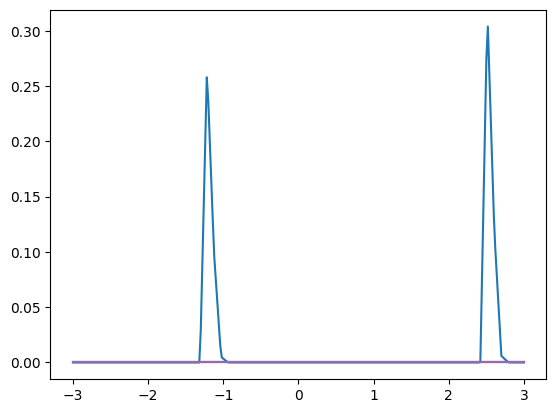

In [63]:
plt.plot(etr[etr.event_number == 0].time, etr[etr.event_number == 0].filtered_events)
plt.plot(etr[etr.event_number == 1].time, etr[etr.event_number == 1].filtered_events)
plt.plot(etr[etr.event_number == 2].time, etr[etr.event_number == 2].filtered_events)
plt.plot(etr[etr.event_number == 3].time, etr[etr.event_number == 3].filtered_events)
plt.plot(etr[etr.event_number == 10].time, etr[etr.event_number == 10].filtered_events)

<Axes: xlabel='time', ylabel='dff'>

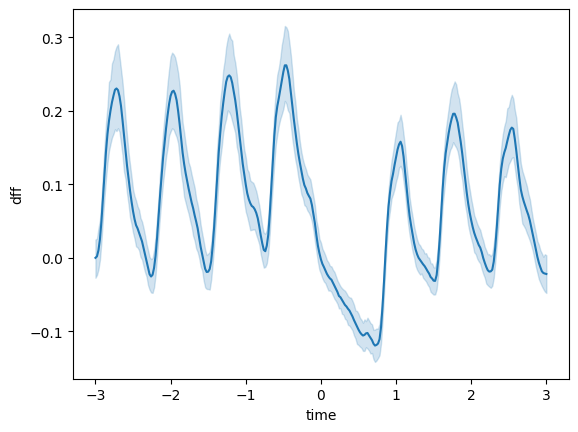

In [47]:
sns.lineplot(
    data=etr,
    x='time',
    y='dff',
    n_boot=500
)